Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as r
import scipy.io as sio
import math

%matplotlib inline

## Helper Functions

In [96]:
def load_data(path, x_col, y_col):
    """
    Reads the contents of a matlab file into
    a dataframe
    
    Parameters
    ----------
    path : String
        Relative path to the input data file
    x_col : String
        Header of the column storing features
    y_col : String
        Header of the column storing actual
        classes
    
    Returns
    -------
    Pandas DataFrame
        Contains the data read from the file
    """
    # Load the data
    data = sio.loadmat(path)
    
    # Convert to dataframe
    data = pd.DataFrame(
                np.hstack(
                    (data[x_col],
                     data[y_col])))
    
    # Define the column headers
    data.columns = ['x1', 'x2', y_col]
    
    # Return the data
    return data

def pre_process(data, y_col):
    """
    Split the input data into a matrix that
    contains all features and a matrix that
    contains all output classes
    
    Parameters
    ----------
    data : Pandas DataFrame
        Contains the input data
    y_col : String
        Header of the result column
    
    Returns
    -------
    N x (d + 1) matrix
        Storing d features for N samples
    N x 1 matrix
        Storing the classification for N
        samples
    """
    data.insert(0, "ones", 1)
    data_cols = list(data.columns.values)
    data_cols.remove(y_col)
    
    X = data[data_cols]
    X = np.matrix(X.values)
    
    Y = data[[y_col]]
    Y = np.matrix(Y.values)
    
    return X, Y

def compute_prediction(W, H):
    """
    Computes the prediction using sigmoid
    function: 1 / (1 + e ^ (-z)) where z
    is the score given by z = w.T * h(x).
    
    Parameters
    ----------
    W : (d + 1) x 1 matrix
        where d is the number of features.
        It must contain the regression 
        coefficients from previous iteration.
    H : N x (d + 1) matrix
        where N is the number of data points
        and d is the number of features. It
        must contain the input dataset.
    
    Returns
    -------
    N x 1 matrix
        which contains the predicted class
        for each input data point
    """
    Z = H * W  # Results in a N x 1 matrix    
    return 1 / (1 + (np.exp(-Z)))  # Predict

def compute_coefficients(W, H, Y, alpha):
    """
    Computes the regression coefficients
    for the next iteration of the program
    using the formula: W - H.T * (Y - P)
    where P is the predicted classification
    for each data input.
    
    Parameters
    ----------
    W : (d + 1) x 1 matrix
        Contains the regression coefficients
        from the previous iteration
    H : N x (d + 1) matrix
        Contains input data in the form of
        a matrix
    Y : N x 1 matrix
        Contains the true classes of all
        inputs
    alpha : Double
        The learning rate for this algorithm
    
    Returns
    -------
    (d + 1) x 1 matrix
        which contains the new values for
        regression coefficients
    """
    P = compute_prediction(W, H)  # Predict
    return W + alpha * (H.T * (Y - P))  # Calculate coefficients

def compute_cost(H, Y, W):
    """
    Computes the overall cost incurred while
    predicting the classification for all
    input data points.
    
    Parameters
    ----------
    H : N x (d + 1) matrix
        Contains the input data in the form
        of a matrix
    Y : N x 1 matrix
        Contains the true classes of all input
        data points
    W : (d + 1) x 1 matrix
        Contains the regression coefficients
    
    Returns
    -------
    Double
        The overall cost
    """
    # Calcualte -(h(x) * w)
    prod = H * W
    prod = -(prod)
    
    # Calculate (1 - 1(y = +1)) * -(h(x) * w)
    first_term = np.multiply((1 - Y), prod)
    
    # Calculate ln(1 + e ^ -(h(x) * w))
    second_term = np.log(1 + np.exp(prod))
    
    # Calculate log likelihood
    cost = first_term - second_term
    
    # Calculate the overall cost
    return np.sum(cost, axis=0)

def gradient_descent(H, Y, W, alpha):
    """
    Performs gradient descent on the given
    data and returns the final regression
    coefficients in the form of a column 
    vector
    
    Parameters
    ----------
    H : N x (d + 1) matrix
        Contains input data in the form of
        a matrix
    Y : N x 1 matrix
        Contains the true classes for each
        input
    W : (d + 1) x 1 matrix
        Contains the initial values of
        regression coefficients
    alpha : Float
        Contains the learning rate of this
        algorithm
    
    Returns
    -------
    (d + 1) x 1 matrix
        which contains the regression
        coefficients at the end of execution
    Array<Double>
        Cost incurred in each iteration
    """
    temp = np.matrix(np.zeros(W.shape))
    error = []
    cost = []
    i = 0
    
    while True:
        # Predict using W from previous iteration
        P = compute_prediction(W, H)
        P = vector_indicator(P)
        
        # Calculate the number of miscalculations and
        # the cost incurred
        error.append(np.sum(np.absolute(Y - P), axis=0).getA()[0][0])
        cost.append(compute_cost(H, Y, W).getA()[0][0])
        
        W = compute_coefficients(W, H, Y, alpha)
        
        # Break out of the loop only when the cost
        # incurred is less than the threshold
        if ((i > 0) and 
            (cost[i] - cost[i - 1] < 0.001)):
            print("Iterations: ", i)            
            print("Miscalculations: ", error[i])
            print("Cost: ", cost[i])
            break
        
        i += 1
    
    return W, cost

def plot_data(data, W):
    x = np.linspace(data.x1.min(), data.x1.max(), 100)
    
    f = 0
    for i in range(len(W)):
        f += x * W.getA()[i][0]
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Draw the plots
    ax.plot(x, f, 'r', label='Classifier')
    ax.scatter(data.x1, data.x2, label='Data', c=data[['Y_trn']])
    
    # Set extra properties for readability
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('x1 vs. x2')
    
    # Set the x and y axis limits for the plot
    x1_min = data.x1.min()
    x1_max = data.x1.max()
    ax.set_xlim(x1_min + 0.2 * x1_min, x1_max + + 0.2 * x1_max)
    
    x2_min = data.x2.min()
    x2_max = data.x2.max()
    ax.set_ylim(x2_min + 0.2 * x2_min, x2_max + + 0.2 * x2_max)

def indicator(score):
    """
    Indicator function which returns 1
    if the score is > 0.5. Else, returns
    0. This method assumes that score has
    already been scaled down to [0, 1] 
    using the sigmoid function.
    
    Parameters
    ----------
    score : Double
        A value between 0 and 1 (both 
        inclusive)
    
    Returns
    -------
    Integer (either 0 or 1)
    """
    return 1 if (score >= 0.5) else 0

vector_indicator = np.vectorize(indicator)

Iterations:  49
Miscalculations:  0.0
Cost:  -0.356130375015
[[ 2.23916838]
 [ 9.70710832]
 [-4.69831297]]


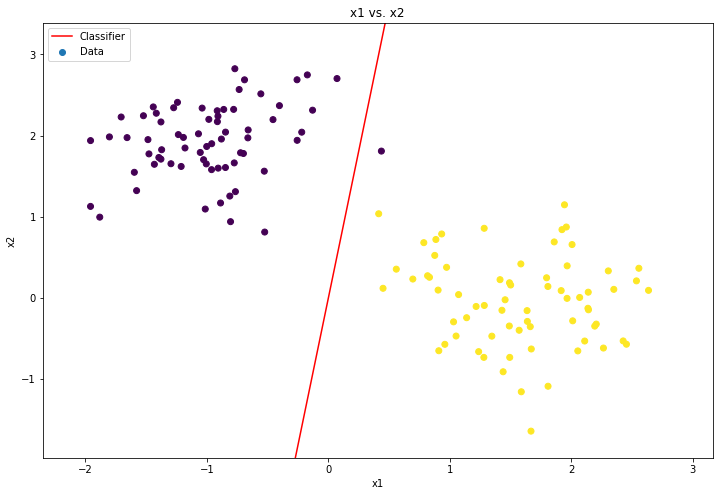

In [97]:
path = "data1.mat"
x_col = 'X_trn'
y_col = 'Y_trn'
data = load_data(path, x_col, y_col)
X, Y = pre_process(data, y_col)
W = np.matrix([0, 0, 0])
W, cost = gradient_descent(X, Y, W.T, 0.1)
plot_data(data, W)
print(W)

In [17]:
temp_x = np.matrix([[1, 2],
                   [3, 4]])
print(temp_x.shape)

temp_w = np.matrix([1, 2])
print(temp_w.T.shape)

temp_y = np.matrix([0, 1])


P = np.matrix([[0.123], 
               [0.5],
               [0.3003],
               [0.980],
               [1]])



res = vector_indicator(P)
print(res)

print(compute_coefficients(temp_w.T, temp_x, temp_y.T, 0.01))

A = np.matrix([[1], 
               [2],
               [3]])

B = np.matrix([[4], 
               [5],
               [6]])

np.multiply(A, B)

compute_cost(temp_x, temp_y.T, temp_w.T)

t = []
for i in range(10):
    t.append(i)
    print(t)

(2, 2)
(2, 1)
[[0]
 [1]
 [0]
 [1]
 [1]]
[[ 0.99006743]
 [ 1.98013453]]
[0]
[0, 1]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
